In [1]:
using HDF5
using ImageView
#using Images
#include("C:/Users/Rutian Zhou/PIV/multi_quickPIV/src/multi_quickPIV.jl")
#using Plots

In [4]:
using PyCall
using PyPlot

In [5]:
using multi_quickPIV

In [6]:
file_path = "memGFP_RA_4_tissue.h5"
function read_h5(folder_path::String, data_name::String)
    h5open(folder_path, "r") do file
        read(file, data_name)
    end
end
img = Float16.(read_h5(file_path, "img"))

1024×1024×49 Array{Float16, 3}:
[:, :, 1] =
  5.0   3.0   5.0   8.0   9.0   7.0  …  39.0  23.0  22.0  14.0  17.0  16.0
  7.0   9.0  12.0   2.0   8.0   8.0     15.0  27.0  22.0  29.0  37.0  26.0
  5.0   5.0  12.0  11.0  10.0   7.0     15.0  17.0  18.0  20.0  29.0  29.0
  9.0   7.0   5.0  10.0  11.0  11.0     15.0  14.0  22.0  24.0  26.0  19.0
  4.0   4.0  11.0  10.0  10.0  10.0     22.0  18.0  19.0  33.0  22.0  26.0
 12.0  10.0  12.0   8.0   8.0  10.0  …  18.0   6.0  24.0  30.0  27.0  29.0
 13.0  11.0  16.0   8.0  12.0  10.0     17.0  21.0  24.0  27.0  36.0  32.0
  9.0  19.0  16.0  10.0   8.0   9.0     20.0  24.0  16.0  26.0  27.0  27.0
 12.0  22.0   9.0  16.0  13.0  16.0     21.0  22.0  24.0  16.0  23.0  37.0
 17.0  18.0  12.0  11.0  20.0  18.0     12.0  21.0  15.0  26.0  30.0  31.0
 21.0  14.0  15.0   9.0  11.0  12.0  …  37.0  35.0  20.0  35.0  35.0  28.0
 17.0  17.0  15.0  11.0  11.0  24.0     29.0  33.0  34.0  32.0  44.0  27.0
 18.0  22.0  11.0  11.0  14.0  20.0     20.0  33.0  16.0

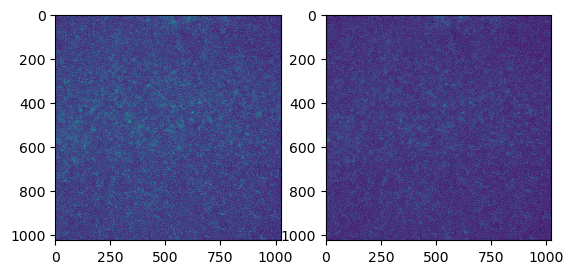

PyObject <matplotlib.image.AxesImage object at 0x0000015E97E370B0>

In [7]:
img1 = img[ :, :, 18]
img2 = img[ :, :, 19]

subplot( 1, 2, 1 ); PyPlot.imshow(img1)
subplot(1, 2, 2); PyPlot.imshow(img2)

## Do PIV only on two images

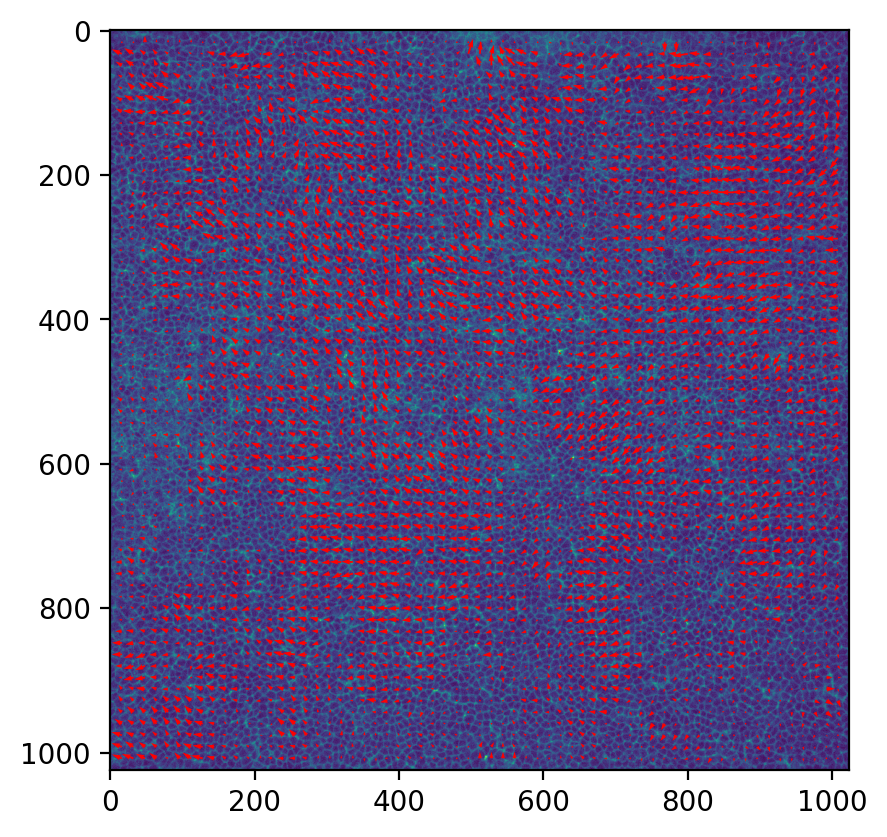

PyObject <matplotlib.quiver.Quiver object at 0x0000015E9FCE2540>

In [9]:
pivparams = multi_quickPIV.setPIVParameters(interSize=(32, 32), searchMargin=(64, 64), step=(16, 16))#, computeSN=true)
VF, _ = multi_quickPIV.PIV( img1, img2, pivparams, precision=16)

IA = multi_quickPIV._isize(pivparams)
ST = multi_quickPIV._step(pivparams)

U = VF[ 1, :, : ]
#U.*= ( SN .> 1.015 )
V = VF[ 2, :, : ]
#V.*= ( SN .> 1.015 )

M = sqrt.( U .^ 2 .+ V .^ 2 ) # Magnitude of the vectors.
U.*= ( M .< 5 )
V.*= ( M .< 5 )
ygrid = [ ( y - 1 )*ST[1] + div( IA[1], 2 ) for y in 1:size(U,1), x in 1:size(U,2) ]
xgrid = [ ( x - 1 )*ST[2] + div( IA[2], 2 ) for y in 1:size(U,1), x in 1:size(U,2) ]

PyPlot.figure( dpi=200 )
PyPlot.imshow( img1)
PyPlot.quiver( xgrid, ygrid, U, V, color="red")

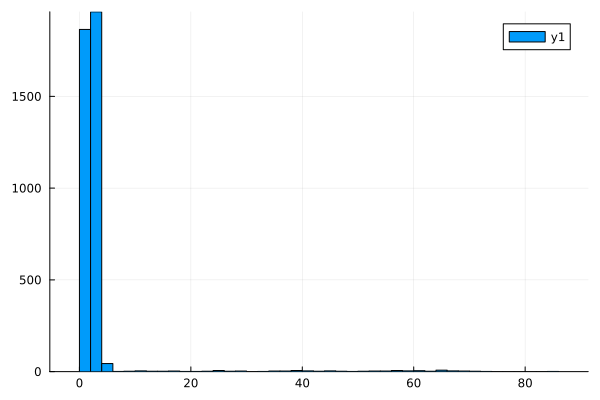

In [10]:
# Plot the distribution of vector lengths for control of the quality of PIV. 
using Plots
histogram(vec(M), bins=50)

## PIV between all two consicutive images and over whole time period. 
Storing at the end the vector fields as .h5 file. 

In [11]:
function PIV_generation(img_series)
    
    pivparams = multi_quickPIV.setPIVParameters(interSize=(32, 32), searchMargin=(64, 64), step=(16, 16))#, computeSN=true)
    IA = multi_quickPIV._isize(pivparams)
    ST = multi_quickPIV._step(pivparams)
    
    m_U = Matrix{Float32}[]
    m_V = Matrix{Float32}[]
    m_xgrid = Matrix{Float32}[]
    m_ygrid = Matrix{Float32}[]
    m_M = Matrix{Float32}[]
    
    for i in 1:size(img_series, 3)-1 
    
        img1 = img_series[ :, :, i]
        img2 = img_series[ :, :, i+1]
        
        VF, _ = multi_quickPIV.PIV( img1, img2, pivparams, precision=16)
        
        U = VF[ 1, :, : ]
        #U.*= ( SN .> 1.015 )
        V = VF[ 2, :, : ]
        #V.*= ( SN .> 1.015 )
        
        M = sqrt.( U .^ 2 .+ V .^ 2 ) # Magnitude of the vectors. 
        U.*= ( M .< 5 ) # Set filter based on magnitude. 
        V.*= ( M .< 5 )
        ygrid = [ ( y - 1 )*ST[1] + div( IA[1], 2 ) for y in 1:size(U,1), x in 1:size(U,2) ]
        xgrid = [ ( x - 1 )*ST[2] + div( IA[2], 2 ) for y in 1:size(U,1), x in 1:size(U,2) ]
    
        push!(m_U, U)
        push!(m_V, V)
        push!(m_xgrid, xgrid)
        push!(m_ygrid, ygrid)
        push!(m_M, M)
    
        print("tu")
        
    end
    # Converting dimensions with time.
    U_data = reduce((x,y) -> cat(x,y,dims=3), m_U)
    V_data = reduce((x,y) -> cat(x,y,dims=3), m_V)
    xgrid_data = reduce((x,y) -> cat(x,y,dims=3), m_xgrid)
    ygrid_data = reduce((x,y) -> cat(x,y,dims=3), m_ygrid)
    M_data = reduce((x,y) -> cat(x,y,dims=3), m_M)

    return U_data, V_data, xgrid_data, ygrid_data, M_data
end


PIV_generation (generic function with 1 method)

In [12]:
U_data, V_data, xgrid_data, ygrid_data, M_data = PIV_generation(img)

tutututututututututututututututututututututututututututututututututututututututututututututututu

(Float32[0.7717163 0.5085805 … 0.8111047 1.0; 1.0921683 1.048582 … 1.0817087 0.76080996; … ; -1.0109723 -0.43109706 … 0.0 1.0177951; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; -1.0712382 -1.1117527 … -0.28734282 -1.0; … ; 1.2289649 0.08286803 … 1.3612679 2.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 1.7325864 1.0; 0.034705173 -0.34757727 … 0.0 2.0; … ; 0.777326 -0.9215622 … 0.6109694 1.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; -2.0 -0.7175466 … -2.2231946 -1.3226793; … ; 2.0 0.9633626 … -1.4258314 -2.456424; 0.0 0.0 … -1.8831092 -2.1950154;;; 0.0 0.0 … 0.0 0.0; -4.0684915 -2.0872006 … -0.28468296 0.0; … ; -1.2762333 -0.23054095 … -1.795493 -2.9117842; -1.0695596 0.0 … -1.1886287 -2.0;;; 0.0 0.0 … 0.0 0.0; -0.740506 -1.9273059 … -0.7708528 0.20441514; … ; 0.0 0.32552606 … -2.6873186 -2.571681; 0.0 0.0 … -1.861081 -2.3355596], Float32[1.04338 1.6724385 … -0.3636953 0.0; 0.8881503 1.5636792 … -1.1962429 -3.597135; … ; 2.717822 1.078824 … -0.0 -0.68613183; 0.0 1.0 … -2.0 -2.0;;; 0.0 -1.0 … 1.0 -

In [13]:
# Store the generated vector field information into .h5 files. 

h5open("memGFP_PIV.h5", "w") do file
    write(file, "U", U_data)
    write(file, "V", V_data)
    write(file, "xgrid", xgrid_data)
    write(file, "ygrid", ygrid_data)
    write(file, "M", M_data)
end